In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')

In [3]:
import os
import re
import json
import pickle as pkl
from os.path import join
from tqdm import trange, tqdm
from os.path import join
from easydict import EasyDict as edict
import numpy as np
import torch as th
import einops
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from os.path import join
from edm_utils import parse_train_logfile
from dataset_utils import onehot2attr_tsr
from stats_plot_utils import estimate_CI, shaded_error, saveallforms
from stats_plot_utils import shaded_error, add_rectangles
from rule_utils import get_rule_list, get_obj_list, get_rule_img, check_consistent
from rule_new_utils import get_rule_annot
from GPT_models.GPT_RAVEN_model_lib import MultiIdxGPT2Model, completion_eval, seqtsr2imgtsr, preprocess_ids

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
GPTroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"

In [5]:
def load_gpt2_raven_model(expdir, pth_name='gpt2_final.pth'):
    # load the model configuration
    config = json.load(open(join(expdir, 'config.json')))
    n_embd = config['n_embd']
    n_layer = config['n_layer']
    n_head = config['n_head']
    n_class = config['n_class']
    heldout_id = config['heldout_id']

    print("Model configuration:")
    print(f"Embedding dimension: {n_embd}")
    print(f"Number of layers: {n_layer}")
    print(f"Number of attention heads: {n_head}")
    print(f"Number of classes: {n_class}")
    print(f"Held-out IDs: {heldout_id}")
    # load the model
    gpt2_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, 
                                   n_embd=n_embd, n_class=n_class, n_layer=n_layer, n_head=n_head)
    gpt2_raven.load_state_dict(th.load(join(expdir, 'ckpt', pth_name)))
    # count the number of parameters
    num_params = sum(p.numel() for p in gpt2_raven.parameters())
    print(f"Number of parameters: {num_params}")
    return gpt2_raven.to('cuda').eval()

## Load example model

In [6]:
expname = "GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019"
expdir = join(GPTroot, expname)

In [7]:
!ls {GPTroot}/GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/ckpt

gpt2_final.pth	     gpt2_step399999.pth  gpt2_step724999.pth
gpt2_init.pth	     gpt2_step424999.pth  gpt2_step749999.pth
gpt2_step124999.pth  gpt2_step449999.pth  gpt2_step74999.pth
gpt2_step149999.pth  gpt2_step474999.pth  gpt2_step774999.pth
gpt2_step174999.pth  gpt2_step499999.pth  gpt2_step799999.pth
gpt2_step199999.pth  gpt2_step49999.pth   gpt2_step824999.pth
gpt2_step224999.pth  gpt2_step524999.pth  gpt2_step849999.pth
gpt2_step249999.pth  gpt2_step549999.pth  gpt2_step874999.pth
gpt2_step24999.pth   gpt2_step574999.pth  gpt2_step899999.pth
gpt2_step274999.pth  gpt2_step599999.pth  gpt2_step924999.pth
gpt2_step299999.pth  gpt2_step624999.pth  gpt2_step949999.pth
gpt2_step324999.pth  gpt2_step649999.pth  gpt2_step974999.pth
gpt2_step349999.pth  gpt2_step674999.pth  gpt2_step999999.pth
gpt2_step374999.pth  gpt2_step699999.pth  gpt2_step99999.pth


In [29]:
config = json.load(open(join(expdir, 'config.json')))
heldout_ids = config['heldout_id']

In [33]:
train_step = 999999

In [8]:
gpt2_raven = load_gpt2_raven_model(expdir, pth_name=f'gpt2_step{train_step}.pth')

Model configuration:
Embedding dimension: 768
Number of layers: 24
Number of attention heads: 12
Number of classes: 0
Held-out IDs: [1, 16, 20, 34, 37]
Number of parameters: 170211102


### Load the training and test datasets

In [10]:
from torch.utils.data import DataLoader, TensorDataset

In [11]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)

In [12]:
attr_seq_tsr = einops.rearrange(train_attrs,  'cls (B R) p (h w) attr -> cls B (R p h w) attr', h=3,w=3,p=3,R=3)
attr_seq_tsr = preprocess_ids(attr_seq_tsr) # add 1 to the attribute indices
y_rule = th.arange(attr_seq_tsr.shape[0], dtype=th.long).unsqueeze(1).repeat(1, attr_seq_tsr.shape[1])
print(attr_seq_tsr.shape, y_rule.shape)
X_train, X_test = attr_seq_tsr[:, :3000], attr_seq_tsr[:, 3000:]
y_train, y_test = y_rule[:, :3000], y_rule[:, 3000:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train = X_train.reshape(-1, 81, 3)
X_test = X_test.reshape(-1, 81, 3)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([40, 4000, 81, 3]) torch.Size([40, 4000])
torch.Size([40, 3000, 81, 3]) torch.Size([40, 1000, 81, 3]) torch.Size([40, 3000]) torch.Size([40, 1000])
torch.Size([120000, 81, 3]) torch.Size([120000])


### Representation recording

In [13]:
import circuit_toolkit
print(circuit_toolkit.__file__)
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

/n/home12/binxuwang/Github/circuit_toolkit/circuit_toolkit/__init__.py


In [14]:
gpt2_raven.gpt2.h[0]

GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2SdpaAttention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [15]:
from collections import defaultdict
# extract_features_GPT
def extract_features_GPT(
    model,
    fetcher,
    data_loader,
    device='cuda',
    cond = False,
    progress_bar=True
):
    """
    Extracts features from specified layers of the model for the given dataset.

    Args:
        model (torch.nn.Module): The neural network model.
        fetcher (FeatureFetcher): An instance of the featureFetcher_module.
        data_loader (DataLoader): DataLoader for the dataset.
        device (str, optional): Device to perform computations on. Defaults to 'cuda'.
        progress_bar (bool, optional): Whether to display a progress bar. Defaults to True.

    Returns:
        dict: A dictionary with layer keys and concatenated activation tensors.
    """
    feature_col = defaultdict(list)
    loader = tqdm(data_loader) if progress_bar else data_loader
    for X_batch, y_batch in loader:
        # Prepare model inputs
        if cond:
            model_kwargs = {'y': y_batch.to(device)}
        else:
            model_kwargs = {'y': th.zeros(X_batch.size(0), dtype=th.long, device=device)}
        # Forward pass with no gradient computation
        with th.no_grad():
            model.forward(X_batch.to(device), **model_kwargs)
        # Collect activations
        for key, activations in fetcher.activations.items():
            # for GPT2Block, the output is a tuple of length 2, the first is the hidden state, the second is sth. else like attentions.
            if isinstance(activations, list) or isinstance(activations, tuple):
                activations = activations[0].detach().cpu()
            feature_col[key].append(activations)

    # Concatenate all activations for each layer
    for key in feature_col:
        feature_col[key] = th.cat(feature_col[key], dim=0)
        print(f"{key}: {feature_col[key].shape}")
    return feature_col

In [16]:
# layers = [0, 5, 11, 17, 23]
layers = [11, 23]
fetcher = featureFetcher_module()
for i in layers:
    fetcher.record_module(gpt2_raven.gpt2.h[i], target_name=f"blocks.{i}", record_raw=True)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [18]:
feature_col = extract_features_GPT(gpt2_raven, fetcher, train_loader, cond=False) # 4mins
feature_col_test = extract_features_GPT(gpt2_raven, fetcher, test_loader, cond=False)

100%|██████████| 118/118 [04:02<00:00,  2.06s/it]


blocks.11: torch.Size([120000, 82, 768])
blocks.23: torch.Size([120000, 82, 768])


100%|██████████| 40/40 [01:20<00:00,  2.00s/it]


blocks.11: torch.Size([40000, 82, 768])
blocks.23: torch.Size([40000, 82, 768])


### Train representation classifier

In [22]:
from repr_probe_lib import train_pca_sgd_classifiers, fit_SGD_linear_classifier, train_dimred_sgd_classifiers # extract_features_GPT, 

In [19]:
feature_avgtoken_train = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avgtoken_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_lasttoken_train = {k: v[:, -1] for k, v in feature_col.items()}
feature_lasttoken_test = {k: v[:, -1] for k, v in feature_col_test.items()}
print(feature_avgtoken_train['blocks.11'].shape)
print(feature_avgtoken_test['blocks.11'].shape)
### Ab initio generation

torch.Size([120000, 768])
torch.Size([40000, 768])


In [35]:
_, _, results_col = train_pca_sgd_classifiers(feature_avgtoken_train, feature_avgtoken_test, y_train, y_test,
                          batch_size=None, num_epochs=5000, noPCA=True, num_classes=40,
                          learning_rate = 0.005, print_every=500, eval_every=500,)

Processing layer: blocks.11
Epoch [1/5000], Loss: 3.8172, Accuracy: 0.0295
Epoch [500/5000], Loss: 0.0957, Accuracy: 0.9691
Test Accuracy: 0.9340
Epoch [1000/5000], Loss: 0.0776, Accuracy: 0.9742
Test Accuracy: 0.9335
Epoch [1500/5000], Loss: 0.0696, Accuracy: 0.9764
Test Accuracy: 0.9318
Epoch [2000/5000], Loss: 0.0650, Accuracy: 0.9773
Test Accuracy: 0.9304
Epoch [2500/5000], Loss: 0.0618, Accuracy: 0.9780
Test Accuracy: 0.9286
Epoch [3000/5000], Loss: 0.0597, Accuracy: 0.9785
Test Accuracy: 0.9277
Epoch [3500/5000], Loss: 0.0580, Accuracy: 0.9788
Test Accuracy: 0.9263
Epoch [4000/5000], Loss: 0.0568, Accuracy: 0.9789
Test Accuracy: 0.9254
Epoch [4500/5000], Loss: 0.0559, Accuracy: 0.9792
Test Accuracy: 0.9250
Epoch [5000/5000], Loss: 0.0551, Accuracy: 0.9793
Test Accuracy: 0.9241
Test Accuracy: 0.9241
Layer blocks.11 - PCA time: 0.03s, PCA transform time: 0.15s, Training time: 34.68s
Processing layer: blocks.23
Epoch [1/5000], Loss: 3.9111, Accuracy: 0.0200
Epoch [500/5000], Loss: 0

In [25]:
_, _, results_col_ltk = train_pca_sgd_classifiers(feature_lasttoken_train, feature_lasttoken_test, y_train, y_test,
                          batch_size=None, num_epochs=5000, noPCA=True, num_classes=40,
                          learning_rate=0.005, print_every=500, eval_every=500,)

Processing layer: blocks.11
Epoch [1/5000], Loss: 3.8619, Accuracy: 0.0228
Epoch [500/5000], Loss: 0.2701, Accuracy: 0.9105
Test Accuracy: 0.8384
Epoch [1000/5000], Loss: 0.2428, Accuracy: 0.9176
Test Accuracy: 0.8368
Epoch [1500/5000], Loss: 0.2303, Accuracy: 0.9212
Test Accuracy: 0.8352
Epoch [2000/5000], Loss: 0.2228, Accuracy: 0.9235
Test Accuracy: 0.8344
Epoch [2500/5000], Loss: 0.2176, Accuracy: 0.9247
Test Accuracy: 0.8337
Epoch [3000/5000], Loss: 0.2139, Accuracy: 0.9257
Test Accuracy: 0.8330
Epoch [3500/5000], Loss: 0.2110, Accuracy: 0.9265
Test Accuracy: 0.8319
Epoch [4000/5000], Loss: 0.2089, Accuracy: 0.9271
Test Accuracy: 0.8316
Epoch [4500/5000], Loss: 0.2073, Accuracy: 0.9275
Test Accuracy: 0.8306
Epoch [5000/5000], Loss: 0.2060, Accuracy: 0.9278
Test Accuracy: 0.8299
Test Accuracy: 0.8299
Layer blocks.11 - PCA time: 0.05s, PCA transform time: 0.17s, Training time: 34.69s
Processing layer: blocks.23
Epoch [1/5000], Loss: 3.8719, Accuracy: 0.0258
Epoch [500/5000], Loss: 0

In [37]:
_, _, results_col_PCA = train_pca_sgd_classifiers(feature_col, feature_col_test, y_train, y_test,
                          batch_size=None, num_epochs=5000, noPCA=False, PC_dim=768, num_classes=40,
                          learning_rate=0.005, print_every=500, eval_every=500, )

Processing layer: blocks.11
PCA components for layer blocks.11: U shape torch.Size([120000, 768]), S shape torch.Size([768]), V shape torch.Size([62976, 768])


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.38 GiB. GPU 

In [38]:
th.cuda.empty_cache()

### Error dissection

In [30]:
from stats_plot_utils import visualize_cm
from sklearn.metrics import confusion_matrix

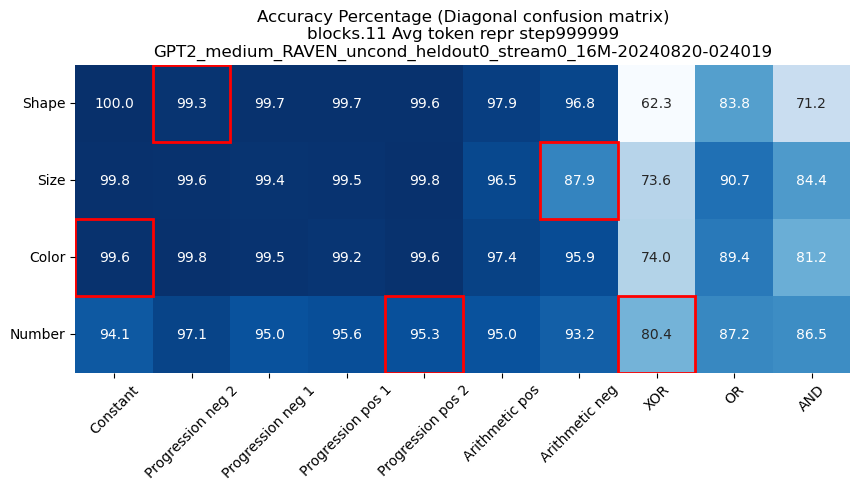

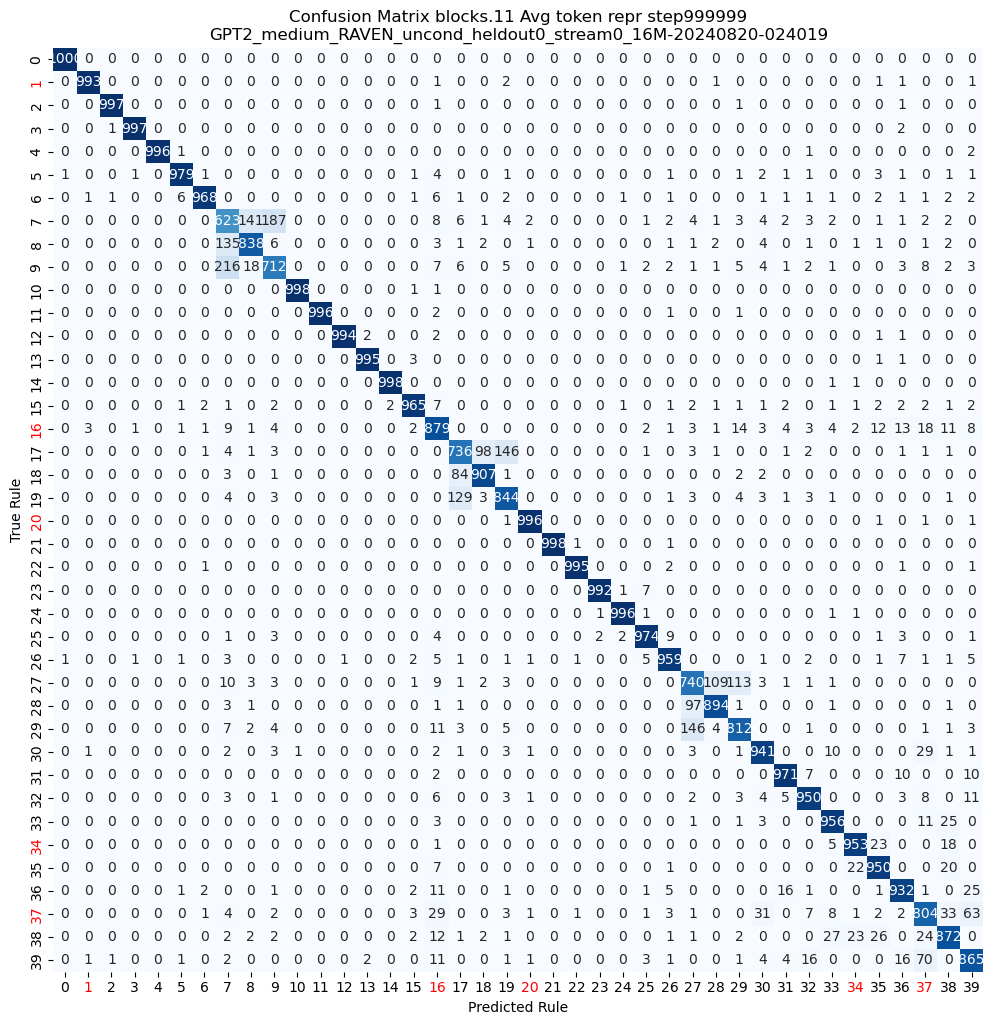

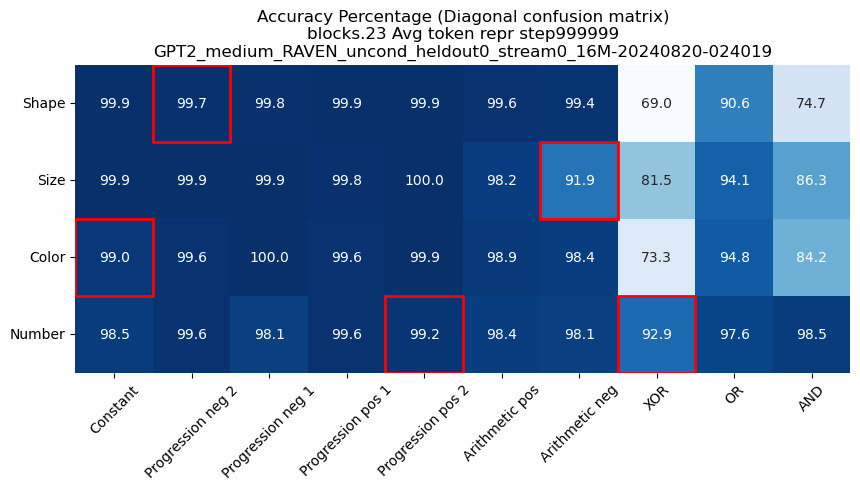

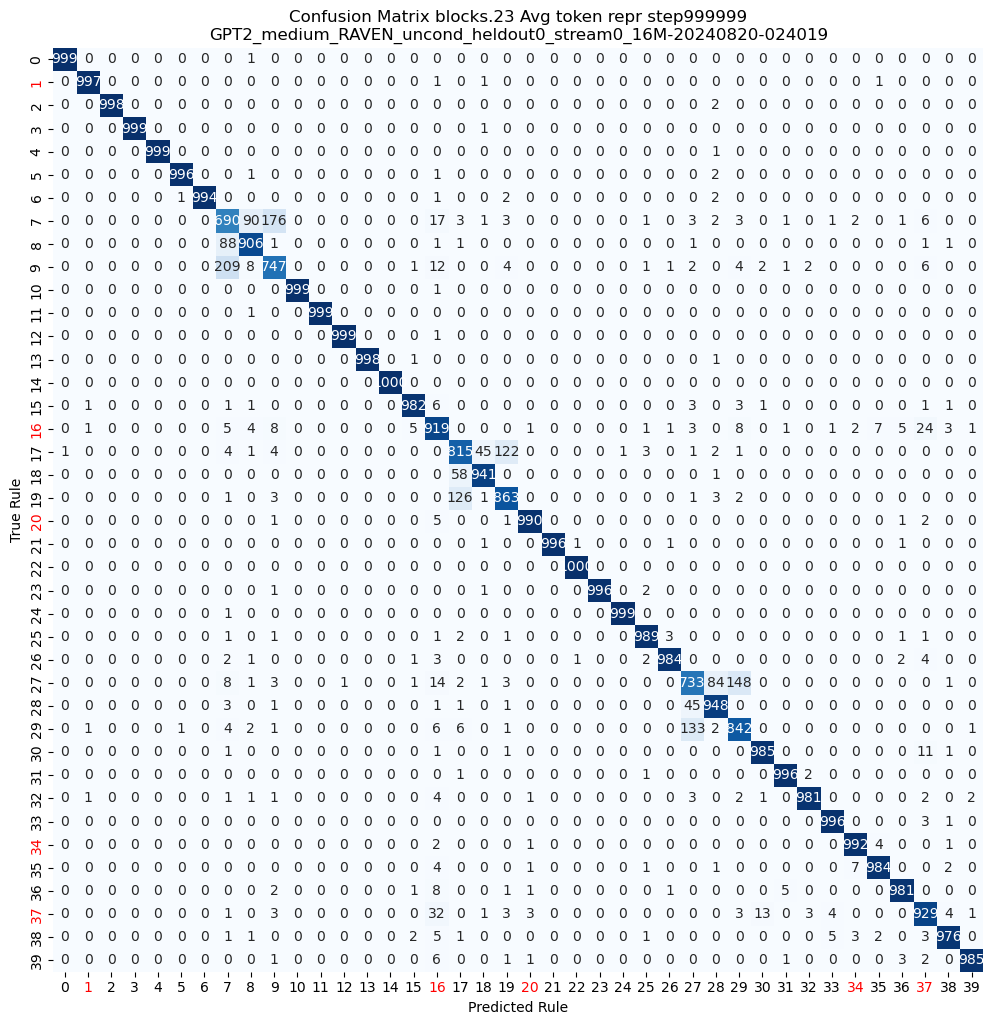

In [36]:
for layername in results_col:
    pred_cls = results_col[layername]['pred_cls'].cpu()
    cm = confusion_matrix(y_test, pred_cls)
    visualize_cm(cm, heldout_rules=heldout_ids, titlestr=f"{layername} Avg token repr step{train_step}\n{expname}")
    ### Ab initio generation

### Ab initio generation

In [ ]:
print("Ab initio generation, sampling: ")
eval_samples_empty = torch.zeros(2048, 81, 3, dtype=th.long).to('cuda')
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_raven, num_mask=81, 
                                                                 device='cuda', strategy="sample", batch_size=256)

Ab initio generation, sampling: 


100%|██████████| 8/8 [01:26<00:00, 10.76s/it]


Completion: C3: 0.140 [286/2048],  valid: 0.444 [2727/6144]


## Scratch

In [ ]:
!ls {expdir}/ckpt

gpt2_ep14.pth  gpt2_ep39.pth  gpt2_ep59.pth  gpt2_ep84.pth  gpt2_final.pth
gpt2_ep19.pth  gpt2_ep44.pth  gpt2_ep64.pth  gpt2_ep89.pth  gpt2_init.pth
gpt2_ep24.pth  gpt2_ep49.pth  gpt2_ep69.pth  gpt2_ep94.pth
gpt2_ep29.pth  gpt2_ep4.pth   gpt2_ep74.pth  gpt2_ep99.pth
gpt2_ep34.pth  gpt2_ep54.pth  gpt2_ep79.pth  gpt2_ep9.pth


In [ ]:
config = json.load(open(join(expdir, 'config.json')))
n_embd = config['n_embd']
n_layer = config['n_layer']
n_head = config['n_head']
n_class = config['n_class']
heldout_id = config['heldout_id']
if True:
    print("Model configuration:")
    print(f"Embedding dimension: {n_embd}")
    print(f"Number of layers: {n_layer}")
    print(f"Number of attention heads: {n_head}")
    print(f"Number of classes: {n_class}")
    print(f"Held-out IDs: {heldout_id}")
gpt2_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, 
                              n_embd=n_embd, n_class=n_class, n_layer=n_layer, n_head=n_head)
gpt2_raven.load_state_dict(th.load(join(expdir, 'ckpt', 'gpt2_final.pth')))
gpt2_raven.to('cuda').eval()

Model configuration:
Embedding dimension: 768
Number of layers: 24
Number of attention heads: 12
Number of classes: 0
Batch size: 64
Evaluation temperature: 1.0
Held-out IDs: [1, 16, 20, 34, 37]


MultiIdxGPT2Model(
  (sep_word_embed): SepWordEmbed(
    (embedding1): Embedding(8, 256)
    (embedding2): Embedding(11, 256)
    (embedding3): Embedding(11, 256)
  )
  (multi_lmhead): SepLMhead(
    (lmhead1): Linear(in_features=256, out_features=8, bias=True)
    (lmhead2): Linear(in_features=256, out_features=11, bias=True)
    (lmhead3): Linear(in_features=256, out_features=11, bias=True)
  )
  (gpt2): GPT2Model(
    (wte): Embedding(27, 768)
    (wpe): Embedding(83, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj):

In [ ]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Block

In [ ]:
type(gpt2_raven.gpt2.h[0])  

transformers.models.gpt2.modeling_gpt2.GPT2Block

In [ ]:
gpt2_raven.gpt2.h[0](th.randn(2, 81, 768).to('cuda')) # note the first output is the hidden state, need to fetch the first. 

AttributeError: 'tuple' object has no attribute 'detach'